### A few initial libraries ###

In [1]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor

from qiskit import IBMQ

from qiskit.test.mock import FakeManhattan
from qiskit.test.mock import FakeMumbai
from qiskit.test.mock import FakeTokyo

### Load device and the device configuration object ###

In [2]:
IBMQ.load_account()

provider = IBMQ.get_provider('ibm-q-ornl')
device = FakeMumbai()

# backend_prop = device.properties()

### Pass manager level 3 (with Trios) ###

In [3]:
"""
Pass manager for optimization level 3 including trios, providing heavy optimization.

Level 3 pass manager: heavy optimization by noise adaptive qubit mapping and
gate cancellation using commutativity rules and unitary synthesis.
"""

#import all original libraries
from qiskit.transpiler.passmanager_config import PassManagerConfig
from qiskit.transpiler.timing_constraints import TimingConstraints
from qiskit.transpiler.passmanager import PassManager

from qiskit.transpiler.passes import Unroller
from qiskit.transpiler.passes import BasisTranslator
from qiskit.transpiler.passes import UnrollCustomDefinitions
from qiskit.transpiler.passes import Unroll3qOrMore
from qiskit.transpiler.passes import CheckMap
from qiskit.transpiler.passes import GateDirection
from qiskit.transpiler.passes import SetLayout
from qiskit.transpiler.passes import CSPLayout
from qiskit.transpiler.passes import TrivialLayout
from qiskit.transpiler.passes import DenseLayout
from qiskit.transpiler.passes import NoiseAdaptiveLayout
from qiskit.transpiler.passes import SabreLayout
from qiskit.transpiler.passes import BarrierBeforeFinalMeasurements
from qiskit.transpiler.passes import BasicSwap
from qiskit.transpiler.passes import LookaheadSwap
from qiskit.transpiler.passes import StochasticSwap
from qiskit.transpiler.passes import SabreSwap
from qiskit.transpiler.passes import FullAncillaAllocation
from qiskit.transpiler.passes import EnlargeWithAncilla
from qiskit.transpiler.passes import FixedPoint
from qiskit.transpiler.passes import Depth
from qiskit.transpiler.passes import RemoveResetInZeroState
from qiskit.transpiler.passes import Optimize1qGatesDecomposition
from qiskit.transpiler.passes import CommutativeCancellation
from qiskit.transpiler.passes import OptimizeSwapBeforeMeasure
from qiskit.transpiler.passes import RemoveDiagonalGatesBeforeMeasure
from qiskit.transpiler.passes import Collect2qBlocks
from qiskit.transpiler.passes import ConsolidateBlocks
from qiskit.transpiler.passes import UnitarySynthesis
from qiskit.transpiler.passes import ApplyLayout
from qiskit.transpiler.passes import Layout2qDistance
from qiskit.transpiler.passes import CheckGateDirection
from qiskit.transpiler.passes import TimeUnitConversion
from qiskit.transpiler.passes import ALAPSchedule
from qiskit.transpiler.passes import ASAPSchedule
from qiskit.transpiler.passes import AlignMeasures
from qiskit.transpiler.passes import ValidatePulseGates
from qiskit.transpiler.passes import Error

from qiskit.transpiler import TranspilerError

#importing all edited libraries
from unroll_3q_or_more_ import Unroll3qOrMore_
from remove_reset_in_zero_state_ import RemoveResetInZeroState_
from remove_diagonal_gates_before_measure_ import RemoveDiagonalGatesBeforeMeasure_
from set_layout_ import SetLayout_
from trivial_layout_ import TrivialLayout_
from layout_2qplus_distance_ import Layout2qPlusDistance_
from csp_layout_ import CSPLayout_
from dense_layout_ import DenseLayout_
from noise_adaptive_layout_ import NoiseAdaptiveLayout_
from full_ancilla_allocation_ import FullAncillaAllocation_
from enlarge_with_ancilla_ import EnlargeWithAncilla_
from apply_layout_ import ApplyLayout_
from check_map_ import CheckMap_
from barrier_before_final_measurements_ import BarrierBeforeFinalMeasurements_
from basic_swap_ import BasicSwap_
from unroll_toffoli_ import UnrollToffoli_
from context_aware_decompose_ import UnrollToffoliContextAware_


def level_3_context_pass_manager(pass_manager_config: PassManagerConfig) -> PassManager:
    """Level 3 pass manager: heavy optimization by noise adaptive qubit mapping and
    gate cancellation using commutativity rules and unitary synthesis.

    This pass manager applies the user-given initial layout. If none is given, a search
    for a perfect layout (i.e. one that satisfies all 2-qubit interactions) is conducted.
    If no such layout is found, and device calibration information is available, the
    circuit is mapped to the qubits with best readouts and to CX gates with highest fidelity.

    The pass manager then transforms the circuit to match the coupling constraints.
    It is then unrolled to the basis, and any flipped cx directions are fixed.
    Finally, optimizations in the form of commutative gate cancellation, resynthesis
    of two-qubit unitary blocks, and redundant reset removal are performed.

    Note:
        In simulators where ``coupling_map=None``, only the unrolling and
        optimization stages are done.

    Args:
        pass_manager_config: configuration of the pass manager.

    Returns:
        a level 3 pass manager.

    Raises:
        TranspilerError: if the passmanager config is invalid.
    """
    basis_gates = pass_manager_config.basis_gates
    coupling_map = pass_manager_config.coupling_map
    initial_layout = pass_manager_config.initial_layout
    
    
    layout_method = pass_manager_config.layout_method or "dense" #works for all cases other than sabre
    print('layout_method: ', layout_method)
    
    #enforcing the basic swap policy at all times
    routing_method = pass_manager_config.routing_method or "basic" #works only for basic
    print('routing method: ', routing_method)
    
    translation_method = pass_manager_config.translation_method or "translator"
    scheduling_method = pass_manager_config.scheduling_method
    instruction_durations = pass_manager_config.instruction_durations
    seed_transpiler = pass_manager_config.seed_transpiler
    backend_properties = pass_manager_config.backend_properties
    approximation_degree = pass_manager_config.approximation_degree
    timing_constraints = pass_manager_config.timing_constraints or TimingConstraints()

    # 1. Unroll to 1q or 2q gates
    _unroll3q = Unroll3qOrMore_()

    # 2. Layout on good qubits if calibration info available, otherwise on dense links
    _given_layout = SetLayout_(initial_layout)

    def _choose_layout_condition(property_set):
        # layout hasn't been set yet
        return not property_set["layout"]

    def _csp_not_found_match(property_set):
        # If a layout hasn't been set by the time we run csp we need to run layout
        if property_set["layout"] is None:
            return True
        # if CSP layout stopped for any reason other than solution found we need
        # to run layout since CSP didn't converge.
        if (
            property_set["CSPLayout_stop_reason"] is not None
            and property_set["CSPLayout_stop_reason"] != "solution found"
        ):
            return True
        return False

    # 2a. If layout method is not set, first try a trivial layout
    _choose_layout_0 = (
        []
        if pass_manager_config.layout_method
        else [
            TrivialLayout_(coupling_map),
            Layout2qPlusDistance_(coupling_map, property_name="trivial_layout_score"),
        ]
    )
    # 2b. If trivial layout wasn't perfect (ie no swaps are needed) then try
    # using CSP layout to find a perfect layout
    _choose_layout_1 = (
        []
        if pass_manager_config.layout_method
        else CSPLayout_(coupling_map, call_limit=10000, time_limit=60, seed=seed_transpiler)
    )

    def _trivial_not_perfect(property_set):
        # Verify that a trivial layout  is perfect. If trivial_layout_score > 0
        # the layout is not perfect. The layout property set is unconditionally
        # set by trivial layout so we clear that before running CSP
        if property_set["trivial_layout_score"] is not None:
            if property_set["trivial_layout_score"] != 0:
                #property_set["layout"]._wrapped = None
                return True
        return False

    # 2c. if CSP didn't converge on a solution use layout_method (dense).
    if layout_method == "trivial":
        _choose_layout_2 = TrivialLayout_(coupling_map)
    elif layout_method == "dense":
        _choose_layout_2 = DenseLayout_(coupling_map, backend_properties)
    elif layout_method == "noise_adaptive":
        _choose_layout_2 = NoiseAdaptiveLayout_(backend_properties)
    elif layout_method == "sabre":
        _choose_layout_2 = SabreLayout(coupling_map, max_iterations=4, seed=seed_transpiler)
    else:
        raise TranspilerError("Invalid layout method %s." % layout_method)

    # 3. Extend dag/layout with ancillas using the full coupling map
    _embed = [FullAncillaAllocation_(coupling_map), EnlargeWithAncilla_(), ApplyLayout_()]

    # 4. Swap to fit the coupling map
    _swap_check = CheckMap_(coupling_map)

    def _swap_condition(property_set):
        return not property_set["is_swap_mapped"]

    _swap = [BarrierBeforeFinalMeasurements_()]
    if routing_method == "basic":
        _swap += [BasicSwap_(coupling_map)]
    elif routing_method == "stochastic":
        _swap += [StochasticSwap(coupling_map, trials=200, seed=seed_transpiler)]
    elif routing_method == "lookahead":
        _swap += [LookaheadSwap(coupling_map, search_depth=5, search_width=6)]
    elif routing_method == "sabre":
        _swap += [SabreSwap(coupling_map, heuristic="decay", seed=seed_transpiler)]
    elif routing_method == "none":
        _swap += [
            Error(
                msg="No routing method selected, but circuit is not routed to device. "
                "CheckMap Error: {check_map_msg}",
                action="raise",
            )
        ]
    else:
        raise TranspilerError("Invalid routing method %s." % routing_method)
    
    #unroll gates in a context-aware way
    _unroll_context = [UnrollToffoliContextAware_(coupling_map)]

    # 5. Unroll to the basis
    if translation_method == "unroller":
        _unroll = [Unroller(basis_gates)]
    elif translation_method == "translator":
        from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel

        _unroll = [UnrollCustomDefinitions(sel, basis_gates), BasisTranslator(sel, basis_gates)]
    elif translation_method == "synthesis":
        _unroll = [
            Unroll3qOrMore(),
            Collect2qBlocks(),
            ConsolidateBlocks(basis_gates=basis_gates),
            UnitarySynthesis(
                basis_gates,
                approximation_degree=approximation_degree,
                coupling_map=coupling_map,
                backend_props=backend_properties,
            ),
        ]
    else:
        raise TranspilerError("Invalid translation method %s." % translation_method)

    # 6. Fix any CX direction mismatch
    _direction_check = [CheckGateDirection(coupling_map)]

    def _direction_condition(property_set):
        return not property_set["is_direction_mapped"]

    _direction = [GateDirection(coupling_map)]

    # 8. Optimize iteratively until no more change in depth. Removes useless gates
    # after reset and before measure, commutes gates and optimizes contiguous blocks.
    _depth_check = [Depth(), FixedPoint("depth")]

    def _opt_control(property_set):
        return not property_set["depth_fixed_point"]

    _reset = [RemoveResetInZeroState()]

    _meas = [OptimizeSwapBeforeMeasure(), RemoveDiagonalGatesBeforeMeasure()]

    _opt = [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(
            basis_gates,
            approximation_degree=approximation_degree,
            coupling_map=coupling_map,
            backend_props=backend_properties,
        ),
        Optimize1qGatesDecomposition(basis_gates),
        CommutativeCancellation(),
    ]

    # 9. Unify all durations (either SI, or convert to dt if known)
    # Schedule the circuit only when scheduling_method is supplied
    _scheduling = [TimeUnitConversion(instruction_durations)]
    if scheduling_method:
        if scheduling_method in {"alap", "as_late_as_possible"}:
            _scheduling += [ALAPSchedule(instruction_durations)]
        elif scheduling_method in {"asap", "as_soon_as_possible"}:
            _scheduling += [ASAPSchedule(instruction_durations)]
        else:
            raise TranspilerError("Invalid scheduling method %s." % scheduling_method)

    # 10. Call measure alignment. Should come after scheduling.
    _alignments = [
        ValidatePulseGates(
            granularity=timing_constraints.granularity, min_length=timing_constraints.min_length
        ),
        AlignMeasures(alignment=timing_constraints.acquire_alignment),
    ]

    # Build pass manager
    pm3 = PassManager()
    pm3.append(_unroll3q)
    pm3.append(_reset + _meas)
    if coupling_map or initial_layout:
        pm3.append(_given_layout)
        pm3.append(_choose_layout_0, condition=_choose_layout_condition)
        pm3.append(_choose_layout_1, condition=_trivial_not_perfect)
        pm3.append(_choose_layout_2, condition=_csp_not_found_match)
        pm3.append(_embed)
        pm3.append(_swap_check)
        pm3.append(_swap, condition=_swap_condition) #_swap performs routing. Only able to route 2 qubit and Toffoli gates.
    pm3.append([Collect2qBlocks()])
    pm3.append(_unroll_context) #the pass which performs the decompositions of the toffoli gate
    pm3.append(_unroll)
    if coupling_map and not coupling_map.is_symmetric:
        pm3.append(_direction_check)
        pm3.append(_direction, condition=_direction_condition)
    pm3.append(_reset)
    pm3.append(_depth_check + _opt + _unroll, do_while=_opt_control)
    pm3.append(_scheduling)
    pm3.append(_alignments)

    return pm3

In [4]:
def level_3_pass_manager(pass_manager_config: PassManagerConfig) -> PassManager:
    """Level 3 pass manager: heavy optimization by noise adaptive qubit mapping and
    gate cancellation using commutativity rules and unitary synthesis.

    This pass manager applies the user-given initial layout. If none is given, a search
    for a perfect layout (i.e. one that satisfies all 2-qubit interactions) is conducted.
    If no such layout is found, and device calibration information is available, the
    circuit is mapped to the qubits with best readouts and to CX gates with highest fidelity.

    The pass manager then transforms the circuit to match the coupling constraints.
    It is then unrolled to the basis, and any flipped cx directions are fixed.
    Finally, optimizations in the form of commutative gate cancellation, resynthesis
    of two-qubit unitary blocks, and redundant reset removal are performed.

    Note:
        In simulators where ``coupling_map=None``, only the unrolling and
        optimization stages are done.

    Args:
        pass_manager_config: configuration of the pass manager.

    Returns:
        a level 3 pass manager.

    Raises:
        TranspilerError: if the passmanager config is invalid.
    """
    basis_gates = pass_manager_config.basis_gates
    coupling_map = pass_manager_config.coupling_map
    initial_layout = pass_manager_config.initial_layout
    
    
    layout_method = pass_manager_config.layout_method or "dense" #works for all cases other than sabre
    print('layout_method: ', layout_method)
    
    #enforcing the basic swap policy at all times
    routing_method = pass_manager_config.routing_method or "basic" #works only for basic
    print('routing method: ', routing_method)
    
    translation_method = pass_manager_config.translation_method or "translator"
    scheduling_method = pass_manager_config.scheduling_method
    instruction_durations = pass_manager_config.instruction_durations
    seed_transpiler = pass_manager_config.seed_transpiler
    backend_properties = pass_manager_config.backend_properties
    approximation_degree = pass_manager_config.approximation_degree
    timing_constraints = pass_manager_config.timing_constraints or TimingConstraints()

    # 1. Unroll to 1q or 2q gates
    _unroll3q = Unroll3qOrMore_()

    # 2. Layout on good qubits if calibration info available, otherwise on dense links
    _given_layout = SetLayout_(initial_layout)

    def _choose_layout_condition(property_set):
        # layout hasn't been set yet
        return not property_set["layout"]

    def _csp_not_found_match(property_set):
        # If a layout hasn't been set by the time we run csp we need to run layout
        if property_set["layout"] is None:
            return True
        # if CSP layout stopped for any reason other than solution found we need
        # to run layout since CSP didn't converge.
        if (
            property_set["CSPLayout_stop_reason"] is not None
            and property_set["CSPLayout_stop_reason"] != "solution found"
        ):
            return True
        return False

    # 2a. If layout method is not set, first try a trivial layout
    _choose_layout_0 = (
        []
        if pass_manager_config.layout_method
        else [
            TrivialLayout_(coupling_map),
            Layout2qPlusDistance_(coupling_map, property_name="trivial_layout_score"),
        ]
    )
    # 2b. If trivial layout wasn't perfect (ie no swaps are needed) then try
    # using CSP layout to find a perfect layout
    _choose_layout_1 = (
        []
        if pass_manager_config.layout_method
        else CSPLayout_(coupling_map, call_limit=10000, time_limit=60, seed=seed_transpiler)
    )

    def _trivial_not_perfect(property_set):
        # Verify that a trivial layout  is perfect. If trivial_layout_score > 0
        # the layout is not perfect. The layout property set is unconditionally
        # set by trivial layout so we clear that before running CSP
        if property_set["trivial_layout_score"] is not None:
            if property_set["trivial_layout_score"] != 0:
                #property_set["layout"]._wrapped = None
                return True
        return False

    # 2c. if CSP didn't converge on a solution use layout_method (dense).
    if layout_method == "trivial":
        _choose_layout_2 = TrivialLayout_(coupling_map)
    elif layout_method == "dense":
        _choose_layout_2 = DenseLayout_(coupling_map, backend_properties)
    elif layout_method == "noise_adaptive":
        _choose_layout_2 = NoiseAdaptiveLayout_(backend_properties)
    elif layout_method == "sabre":
        _choose_layout_2 = SabreLayout(coupling_map, max_iterations=4, seed=seed_transpiler)
    else:
        raise TranspilerError("Invalid layout method %s." % layout_method)

    # 3. Extend dag/layout with ancillas using the full coupling map
    _embed = [FullAncillaAllocation_(coupling_map), EnlargeWithAncilla_(), ApplyLayout_()]

    # 4. Swap to fit the coupling map
    _swap_check = CheckMap_(coupling_map)

    def _swap_condition(property_set):
        return not property_set["is_swap_mapped"]

    _swap = [BarrierBeforeFinalMeasurements_()]
    if routing_method == "basic":
        _swap += [BasicSwap_(coupling_map)]
    elif routing_method == "stochastic":
        _swap += [StochasticSwap(coupling_map, trials=200, seed=seed_transpiler)]
    elif routing_method == "lookahead":
        _swap += [LookaheadSwap(coupling_map, search_depth=5, search_width=6)]
    elif routing_method == "sabre":
        _swap += [SabreSwap(coupling_map, heuristic="decay", seed=seed_transpiler)]
    elif routing_method == "none":
        _swap += [
            Error(
                msg="No routing method selected, but circuit is not routed to device. "
                "CheckMap Error: {check_map_msg}",
                action="raise",
            )
        ]
    else:
        raise TranspilerError("Invalid routing method %s." % routing_method)
    
    #unroll toffoli in a layout-aware way
    _unroll_toffoli = [UnrollToffoli_(coupling_map)]

    # 5. Unroll to the basis
    if translation_method == "unroller":
        _unroll = [Unroller(basis_gates)]
    elif translation_method == "translator":
        from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel

        _unroll = [UnrollCustomDefinitions(sel, basis_gates), BasisTranslator(sel, basis_gates)]
    elif translation_method == "synthesis":
        _unroll = [
            Unroll3qOrMore(),
            Collect2qBlocks(),
            ConsolidateBlocks(basis_gates=basis_gates),
            UnitarySynthesis(
                basis_gates,
                approximation_degree=approximation_degree,
                coupling_map=coupling_map,
                backend_props=backend_properties,
            ),
        ]
    else:
        raise TranspilerError("Invalid translation method %s." % translation_method)

    # 6. Fix any CX direction mismatch
    _direction_check = [CheckGateDirection(coupling_map)]

    def _direction_condition(property_set):
        return not property_set["is_direction_mapped"]

    _direction = [GateDirection(coupling_map)]

    # 8. Optimize iteratively until no more change in depth. Removes useless gates
    # after reset and before measure, commutes gates and optimizes contiguous blocks.
    _depth_check = [Depth(), FixedPoint("depth")]

    def _opt_control(property_set):
        return not property_set["depth_fixed_point"]

    _reset = [RemoveResetInZeroState()]

    _meas = [OptimizeSwapBeforeMeasure(), RemoveDiagonalGatesBeforeMeasure()]

    _opt = [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(
            basis_gates,
            approximation_degree=approximation_degree,
            coupling_map=coupling_map,
            backend_props=backend_properties,
        ),
        Optimize1qGatesDecomposition(basis_gates),
        CommutativeCancellation(),
    ]

    # 9. Unify all durations (either SI, or convert to dt if known)
    # Schedule the circuit only when scheduling_method is supplied
    _scheduling = [TimeUnitConversion(instruction_durations)]
    if scheduling_method:
        if scheduling_method in {"alap", "as_late_as_possible"}:
            _scheduling += [ALAPSchedule(instruction_durations)]
        elif scheduling_method in {"asap", "as_soon_as_possible"}:
            _scheduling += [ASAPSchedule(instruction_durations)]
        else:
            raise TranspilerError("Invalid scheduling method %s." % scheduling_method)

    # 10. Call measure alignment. Should come after scheduling.
    _alignments = [
        ValidatePulseGates(
            granularity=timing_constraints.granularity, min_length=timing_constraints.min_length
        ),
        AlignMeasures(alignment=timing_constraints.acquire_alignment),
    ]

    # Build pass manager
    pm3 = PassManager()
    pm3.append(_unroll3q)
    pm3.append(_reset + _meas)
    if coupling_map or initial_layout:
        pm3.append(_given_layout)
        pm3.append(_choose_layout_0, condition=_choose_layout_condition)
        pm3.append(_choose_layout_1, condition=_trivial_not_perfect)
        pm3.append(_choose_layout_2, condition=_csp_not_found_match)
        pm3.append(_embed)
        pm3.append(_swap_check)
        pm3.append(_swap, condition=_swap_condition) #_swap performs routing. Only able to route 2 qubit and Toffoli gates.
    pm3.append(_unroll_toffoli) #the pass which performs the decompositions of the toffoli gate
    pm3.append(_unroll)
    if coupling_map and not coupling_map.is_symmetric:
        pm3.append(_direction_check)
        pm3.append(_direction, condition=_direction_condition)
    pm3.append(_reset)
    pm3.append(_depth_check + _opt + _unroll, do_while=_opt_control)
    pm3.append(_scheduling)
    pm3.append(_alignments)

    return pm3

### Pass Manager Config ###

In [5]:
from typing import List, Union, Dict, Callable, Any, Optional, Tuple

from qiskit.dagcircuit import DAGCircuit
from qiskit.providers import BaseBackend
from qiskit.providers.backend import Backend
from qiskit.providers.models import BackendProperties
from qiskit.providers.models.backendproperties import Gate
from qiskit.pulse import Schedule
from qiskit.tools.parallel import parallel_map
from qiskit.transpiler import Layout, CouplingMap, PropertySet, PassManager
from qiskit.transpiler.basepasses import BasePass
from qiskit.transpiler.exceptions import TranspilerError
from qiskit.transpiler.instruction_durations import InstructionDurations, InstructionDurationsType
from qiskit.transpiler.passes import ApplyLayout
from qiskit.transpiler.passmanager_config import PassManagerConfig
from qiskit.transpiler.timing_constraints import TimingConstraints

def _parse_transpile_args(
    circuits,
    backend,
    basis_gates = None,
    coupling_map = None,
    backend_properties = None,
    initial_layout = None,
    layout_method = None,
    routing_method = None,
    translation_method = None,
    scheduling_method = None,
    instruction_durations = None,
    dt = None,
    approximation_degree = None,
    seed_transpiler = None,
    optimization_level = None,
    callback = None,
    output_name = None,
    timing_constraints = None,
) -> List[Dict]:
    """Resolve the various types of args allowed to the transpile() function through
    duck typing, overriding args, etc. Refer to the transpile() docstring for details on
    what types of inputs are allowed.

    Here the args are resolved by converting them to standard instances, and prioritizing
    them in case a transpile option is passed through multiple args (explicitly setting an
    arg has more priority than the arg set by backend).

    Returns:
        list[dicts]: a list of transpile parameters.

    Raises:
        TranspilerError: If instruction_durations are required but not supplied or found.
    """
    if initial_layout is not None and layout_method is not None:
        warnings.warn("initial_layout provided; layout_method is ignored.", UserWarning)
    # Each arg could be single or a list. If list, it must be the same size as
    # number of circuits. If single, duplicate to create a list of that size.
    num_circuits = len(circuits)

    basis_gates = _parse_basis_gates(basis_gates, backend, circuits)
    faulty_qubits_map = _parse_faulty_qubits_map(backend, num_circuits)
    coupling_map = _parse_coupling_map(coupling_map, backend, num_circuits)
    backend_properties = _parse_backend_properties(backend_properties, backend, num_circuits)
    backend_num_qubits = _parse_backend_num_qubits(backend, num_circuits)
    initial_layout = _parse_initial_layout(initial_layout, circuits)
    layout_method = _parse_layout_method(layout_method, num_circuits)
    routing_method = _parse_routing_method(routing_method, num_circuits)
    translation_method = _parse_translation_method(translation_method, num_circuits)
    approximation_degree = _parse_approximation_degree(approximation_degree, num_circuits)
    seed_transpiler = _parse_seed_transpiler(seed_transpiler, num_circuits)
    optimization_level = _parse_optimization_level(optimization_level, num_circuits)
    output_name = _parse_output_name(output_name, circuits)
    callback = _parse_callback(callback, num_circuits)
    durations = _parse_instruction_durations(backend, instruction_durations, dt, circuits)
    scheduling_method = _parse_scheduling_method(scheduling_method, num_circuits)
    timing_constraints = _parse_timing_constraints(backend, timing_constraints, num_circuits)
    if scheduling_method and any(d is None for d in durations):
        raise TranspilerError(
            "Transpiling a circuit with a scheduling method"
            "requires a backend or instruction_durations."
        )

    list_transpile_args = []
    for args in zip(
        basis_gates,
        coupling_map,
        backend_properties,
        initial_layout,
        layout_method,
        routing_method,
        translation_method,
        scheduling_method,
        durations,
        approximation_degree,
        timing_constraints,
        seed_transpiler,
        optimization_level,
        output_name,
        callback,
        backend_num_qubits,
        faulty_qubits_map,
    ):
        transpile_args = {
            "pass_manager_config": PassManagerConfig(
                basis_gates=args[0],
                coupling_map=args[1],
                backend_properties=args[2],
                initial_layout=args[3],
                layout_method=args[4],
                routing_method=args[5],
                translation_method=args[6],
                scheduling_method=args[7],
                instruction_durations=args[8],
                approximation_degree=args[9],
                timing_constraints=args[10],
                seed_transpiler=args[11],
            ),
            "optimization_level": args[12],
            "output_name": args[13],
            "callback": args[14],
            "backend_num_qubits": args[15],
            "faulty_qubits_map": args[16],
        }
        list_transpile_args.append(transpile_args)

    return list_transpile_args


def _create_faulty_qubits_map(backend):
    """If the backend has faulty qubits, those should be excluded. A faulty_qubit_map is a map
    from working qubit in the backend to dummy qubits that are consecutive and connected."""
    faulty_qubits_map = None
    if backend is not None:
        if backend.properties():
            faulty_qubits = backend.properties().faulty_qubits()
            faulty_edges = [gates.qubits for gates in backend.properties().faulty_gates()]
        else:
            faulty_qubits = []
            faulty_edges = []

        if faulty_qubits or faulty_edges:
            faulty_qubits_map = {}
            configuration = backend.configuration()
            full_coupling_map = configuration.coupling_map
            functional_cm_list = [
                edge
                for edge in full_coupling_map
                if (set(edge).isdisjoint(faulty_qubits) and edge not in faulty_edges)
            ]

            connected_working_qubits = CouplingMap(functional_cm_list).largest_connected_component()
            dummy_qubit_counter = 0
            for qubit in range(configuration.n_qubits):
                if qubit in connected_working_qubits:
                    faulty_qubits_map[qubit] = dummy_qubit_counter
                    dummy_qubit_counter += 1
                else:
                    faulty_qubits_map[qubit] = None
    return faulty_qubits_map


def _parse_basis_gates(basis_gates, backend, circuits):
    # try getting basis_gates from user, else backend
    if basis_gates is None:
        if getattr(backend, "configuration", None):
            basis_gates = getattr(backend.configuration(), "basis_gates", None)
    # basis_gates could be None, or a list of basis, e.g. ['u3', 'cx']
    if basis_gates is None or (
        isinstance(basis_gates, list) and all(isinstance(i, str) for i in basis_gates)
    ):
        basis_gates = [basis_gates] * len(circuits)

    return basis_gates


def _parse_coupling_map(coupling_map, backend, num_circuits):
    # try getting coupling_map from user, else backend
    if coupling_map is None:
        if getattr(backend, "configuration", None):
            configuration = backend.configuration()
            if hasattr(configuration, "coupling_map") and configuration.coupling_map:
                faulty_map = _create_faulty_qubits_map(backend)
                if faulty_map:
                    faulty_edges = [gate.qubits for gate in backend.properties().faulty_gates()]
                    functional_gates = [
                        edge for edge in configuration.coupling_map if edge not in faulty_edges
                    ]
                    coupling_map = CouplingMap()
                    for qubit1, qubit2 in functional_gates:
                        if faulty_map[qubit1] is not None and faulty_map[qubit2] is not None:
                            coupling_map.add_edge(faulty_map[qubit1], faulty_map[qubit2])
                    if configuration.n_qubits != coupling_map.size():
                        warnings.warn(
                            "The backend has currently some qubits/edges out of service."
                            " This temporarily reduces the backend size from "
                            f"{configuration.n_qubits} to {coupling_map.size()}",
                            UserWarning,
                        )
                else:
                    coupling_map = CouplingMap(configuration.coupling_map)

    # coupling_map could be None, or a list of lists, e.g. [[0, 1], [2, 1]]
    if coupling_map is None or isinstance(coupling_map, CouplingMap):
        coupling_map = [coupling_map] * num_circuits
    elif isinstance(coupling_map, list) and all(
        isinstance(i, list) and len(i) == 2 for i in coupling_map
    ):
        coupling_map = [coupling_map] * num_circuits

    coupling_map = [CouplingMap(cm) if isinstance(cm, list) else cm for cm in coupling_map]

    return coupling_map


def _parse_backend_properties(backend_properties, backend, num_circuits):
    # try getting backend_properties from user, else backend
    if backend_properties is None:
        if getattr(backend, "properties", None):
            backend_properties = backend.properties()
            if backend_properties and (
                backend_properties.faulty_qubits() or backend_properties.faulty_gates()
            ):
                faulty_qubits = sorted(backend_properties.faulty_qubits(), reverse=True)
                faulty_edges = [gates.qubits for gates in backend_properties.faulty_gates()]
                # remove faulty qubits in backend_properties.qubits
                for faulty_qubit in faulty_qubits:
                    del backend_properties.qubits[faulty_qubit]

                gates = []
                for gate in backend_properties.gates:
                    # remove gates using faulty edges or with faulty qubits (and remap the
                    # gates in terms of faulty_qubits_map)
                    faulty_qubits_map = _create_faulty_qubits_map(backend)
                    if (
                        any(faulty_qubits_map[qubits] is not None for qubits in gate.qubits)
                        or gate.qubits in faulty_edges
                    ):
                        continue
                    gate_dict = gate.to_dict()
                    replacement_gate = Gate.from_dict(gate_dict)
                    gate_dict["qubits"] = [faulty_qubits_map[qubit] for qubit in gate.qubits]
                    args = "_".join([str(qubit) for qubit in gate_dict["qubits"]])
                    gate_dict["name"] = "{}{}".format(gate_dict["gate"], args)
                    gates.append(replacement_gate)

                backend_properties.gates = gates
    if not isinstance(backend_properties, list):
        backend_properties = [backend_properties] * num_circuits
    return backend_properties


def _parse_backend_num_qubits(backend, num_circuits):
    if backend is None:
        return [None] * num_circuits
    if not isinstance(backend, list):
        return [backend.configuration().n_qubits] * num_circuits
    backend_num_qubits = []
    for a_backend in backend:
        backend_num_qubits.append(a_backend.configuration().n_qubits)
    return backend_num_qubits


def _parse_initial_layout(initial_layout, circuits):
    # initial_layout could be None, or a list of ints, e.g. [0, 5, 14]
    # or a list of tuples/None e.g. [qr[0], None, qr[1]] or a dict e.g. {qr[0]: 0}
    def _layout_from_raw(initial_layout, circuit):
        if initial_layout is None or isinstance(initial_layout, Layout):
            return initial_layout
        elif isinstancelist(initial_layout):
            if all(isinstanceint(elem) for elem in initial_layout):
                initial_layout = Layout.from_intlist(initial_layout, *circuit.qregs)
            elif all(elem is None or isinstance(elem, Qubit) for elem in initial_layout):
                initial_layout = Layout.from_qubit_list(initial_layout, *circuit.qregs)
        elif isinstance(initial_layout, dict):
            initial_layout = Layout(initial_layout)
        else:
            raise TranspilerError("The initial_layout parameter could not be parsed")
        return initial_layout

    # multiple layouts?
    if isinstance(initial_layout, list) and any(
        isinstance(i, (list, dict)) for i in initial_layout
    ):
        initial_layout = [
            _layout_from_raw(lo, circ) if isinstance(lo, (list, dict)) else lo
            for lo, circ in zip(initial_layout, circuits)
        ]
    else:
        # even if one layout, but multiple circuits, the layout needs to be adapted for each
        initial_layout = [_layout_from_raw(initial_layout, circ) for circ in circuits]

    if not isinstance(initial_layout, list):
        initial_layout = [initial_layout] * len(circuits)

    return initial_layout


def _parse_layout_method(layout_method, num_circuits):
    if not isinstance(layout_method, list):
        layout_method = [layout_method] * num_circuits
    return layout_method


def _parse_routing_method(routing_method, num_circuits):
    if not isinstance(routing_method, list):
        routing_method = [routing_method] * num_circuits
    return routing_method


def _parse_translation_method(translation_method, num_circuits):
    if not isinstance(translation_method, list):
        translation_method = [translation_method] * num_circuits
    return translation_method


def _parse_scheduling_method(scheduling_method, num_circuits):
    if not isinstance(scheduling_method, list):
        scheduling_method = [scheduling_method] * num_circuits
    return scheduling_method


def _parse_instruction_durations(backend, inst_durations, dt, circuits):
    """Create a list of ``InstructionDuration``s. If ``inst_durations`` is provided,
    the backend will be ignored, otherwise, the durations will be populated from the
    backend. If any circuits have gate calibrations, those calibration durations would
    take precedence over backend durations, but be superceded by ``inst_duration``s.
    """
    if not inst_durations:
        backend_durations = InstructionDurations()
        try:
            backend_durations = InstructionDurations.from_backend(backend)
        except AttributeError:
            pass

    durations = []
    for circ in circuits:
        circ_durations = InstructionDurations()
        if not inst_durations:
            circ_durations.update(backend_durations, dt or backend_durations.dt)

        if circ.calibrations:
            cal_durations = []
            for gate, gate_cals in circ.calibrations.items():
                for (qubits, _), schedule in gate_cals.items():
                    cal_durations.append((gate, qubits, schedule.duration))
            circ_durations.update(cal_durations, circ_durations.dt)

        if inst_durations:
            circ_durations.update(inst_durations, dt or getattr(inst_durations, "dt", None))

        durations.append(circ_durations)
    return durations


def _parse_approximation_degree(approximation_degree, num_circuits):
    if not isinstance(approximation_degree, list):
        approximation_degree = [approximation_degree] * num_circuits
    if not all(0.0 <= d <= 1.0 for d in approximation_degree if d):
        raise TranspilerError("Approximation degree must be in [0.0, 1.0]")
    return approximation_degree


def _parse_seed_transpiler(seed_transpiler, num_circuits):
    if not isinstance(seed_transpiler, list):
        seed_transpiler = [seed_transpiler] * num_circuits
    return seed_transpiler


def _parse_optimization_level(optimization_level, num_circuits):
    if not isinstance(optimization_level, list):
        optimization_level = [optimization_level] * num_circuits
    return optimization_level


def _parse_pass_manager(pass_manager, num_circuits):
    if not isinstance(pass_manager, list):
        pass_manager = [pass_manager] * num_circuits
    return pass_manager


def _parse_callback(callback, num_circuits):
    if not isinstance(callback, list):
        callback = [callback] * num_circuits
    return callback


def _parse_faulty_qubits_map(backend, num_circuits):
    if backend is None:
        return [None] * num_circuits
    if not isinstance(backend, list):
        return [_create_faulty_qubits_map(backend)] * num_circuits
    faulty_qubits_map = []
    for a_backend in backend:
        faulty_qubits_map.append(_create_faulty_qubits_map(a_backend))
    return faulty_qubits_map


def _parse_output_name(output_name, circuits):
    # naming and returning circuits
    # output_name could be either a string or a list
    if output_name is not None:
        if isinstance(output_name, str):
            # single circuit
            if len(circuits) == 1:
                return [output_name]
            # multiple circuits
            else:
                raise TranspilerError(
                    "Expected a list object of length equal "
                    + "to that of the number of circuits "
                    + "being transpiled"
                )
        elif isinstance(output_name, list):
            if len(circuits) == len(output_name) and all(
                isinstance(name, str) for name in output_name
            ):
                return output_name
            else:
                raise TranspilerError(
                    "The length of output_name list "
                    "must be equal to the number of "
                    "transpiled circuits and the output_name "
                    "list should be strings."
                )
        else:
            raise TranspilerError(
                "The parameter output_name should be a string or a"
                "list of strings: %s was used." % type(output_name)
            )
    else:
        return [circuit.name for circuit in circuits]


def _parse_timing_constraints(backend, timing_constraints, num_circuits):

    if backend is None and timing_constraints is None:
        timing_constraints = TimingConstraints()
    else:
        if timing_constraints is None:
            # get constraints from backend
            timing_constraints = getattr(backend.configuration(), "timing_constraints", {})
        timing_constraints = TimingConstraints(**timing_constraints)

    return [timing_constraints] * num_circuits

In [6]:
#benchmark is copied from https://github.com/jmbaker94/quantumcircuitbenchmarks/tree/master/quantumcircuitbenchmarks
#CNX is the same as multi-controlled toffoli
def cnx_halfdirty(circuit, controls, target, ancilla):
    if len(controls) == 2:
        circuit.toffoli(controls[0], controls[1], target)
    elif len(controls) == 1:
        circuit.cx(controls[0], target)
    else:
        bits = []
        bits.append(controls[0])
        
        for i in range(1, len(controls) - 1):
            bits.append(controls[i])
            bits.append(ancilla[i-1])
        bits.append(controls[-1])
        bits.append(target)
        
        for i in range(len(bits) - 1, 0, -2):
            circuit.toffoli(bits[i-2], bits[i-1], bits[i])
        
        for i in range(4, len(bits) - 2, 2):
            circuit.toffoli(bits[i-2], bits[i-1], bits[i])
            
        for i in range(len(bits) - 1, 0, -2):
            circuit.toffoli(bits[i-2], bits[i-1], bits[i])
            
        for i in range(4, len(bits) - 2, 2):
            circuit.toffoli(bits[i-2], bits[i-1], bits[i])

def generate_cnx_halfdirty(n):
    c = qiskit.circuit.QuantumCircuit(n)
    
    qs = range(n)
    
    assert (n + 3) % 2 == 0
    
    reg_len = int((n + 3)  / 2)
    cnx_halfdirty(c, qs[:reg_len -1], qs[reg_len -1], qs[reg_len:])
    return c

In [7]:
circuit = generate_cnx_halfdirty(7)

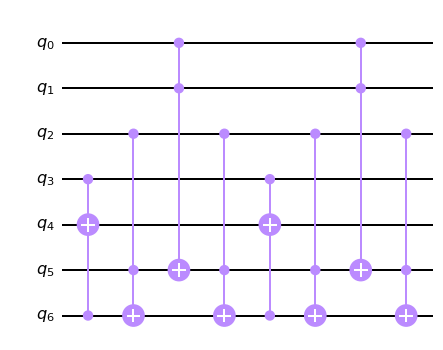

In [8]:
circuit.draw(output = 'mpl')

In [9]:
backend = FakeMumbai()

backend_prop = backend.properties()

In [10]:
transpile_args = _parse_transpile_args([circuit], backend, seed_transpiler = 0)

In [11]:
pass_manager_config = transpile_args[0]['pass_manager_config']

In [12]:
pm_context = level_3_pass_manager(pass_manager_config)

layout_method:  dense
routing method:  basic


In [13]:
t_circ = pm_context.run(circuit)

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  nonexistent solution
Layout({
5: Qubit(QuantumRegister(7, 'q'), 0),
7: Qubit(QuantumRegister(7, 'q'), 1),
3: Qubit(QuantumRegister(7, 'q'), 2),
4: Qubit(QuantumRegister(7, 'q'), 3),
2: Qubit(QuantumRegister(7, 'q'), 4),
1: Qubit(QuantumRegister(7, 'q'), 5),
0: Qubit(QuantumRegister(7, 'q'), 6)
})
The arguments for the toffoli node are:  Qubit(QuantumRegister(27, 'q'), 0) Qubit(QuantumRegister(27, 'q'), 2) Qubit(QuantumRegister(27, 'q'), 1)
The distances between the toffoli qubits are:  2 between qubits 0 and 1
The distances between the toffoli qubits are:  1 between qubits 1 and 2
The distances between the toffoli qubits are:  1 between qubits 0 and 2
The physical qubits for the toffoli are:  0 2 1
The required toffoli will be decomposed using an 8 cnot decomposition - two in center
The arguments for the toffoli node are:  Qubit(QuantumRegister(27, 'q'), 4) Qubit(QuantumRegister(27, 'q'), 0) Qubit(QuantumRegister(27, 'q'), 1)
The dist

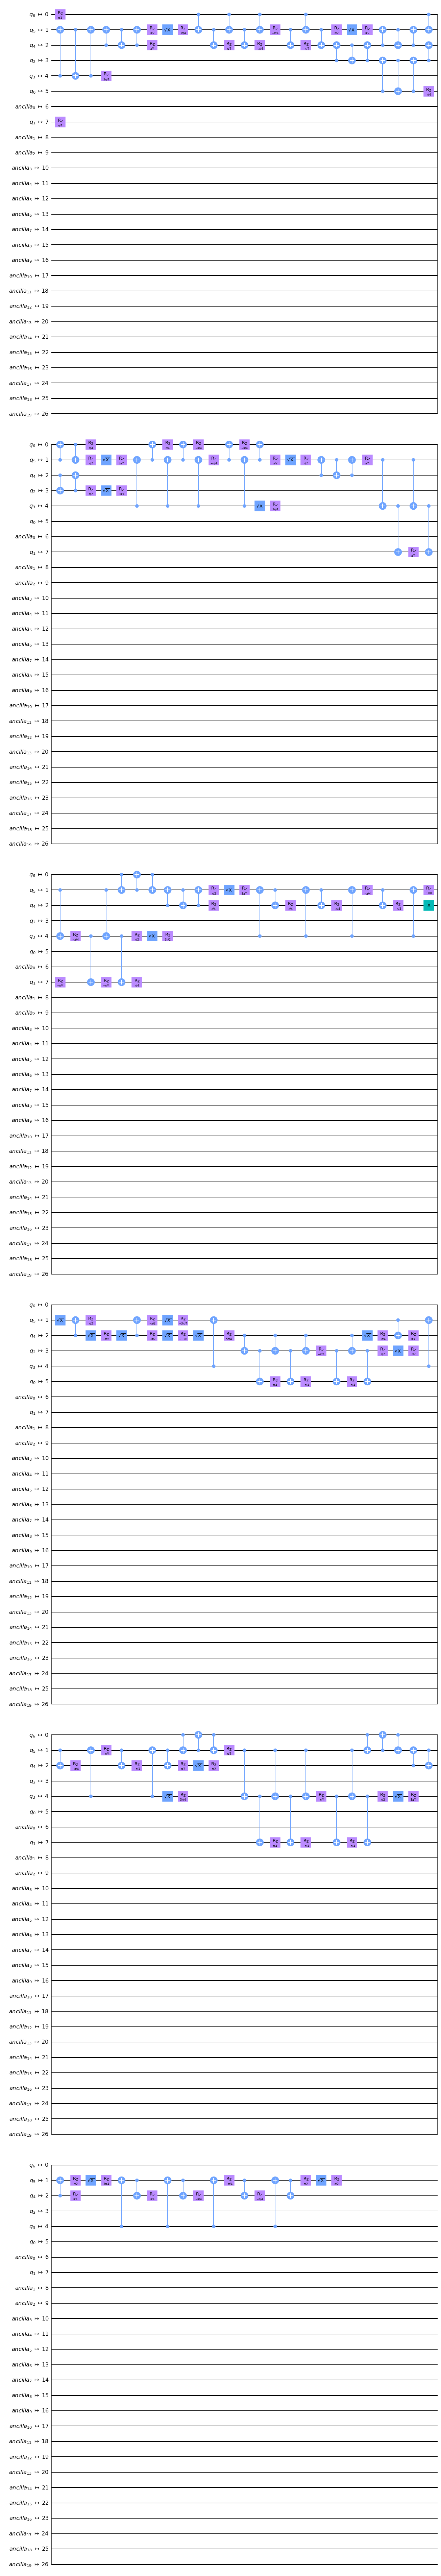

In [14]:
t_circ.draw(output = 'mpl')

In [15]:
t_circ.count_ops()

OrderedDict([('cx', 104), ('rz', 78), ('sx', 21), ('x', 1)])

In [16]:
t_circ.size()

204

In [17]:
t_circ.depth()

134

In [18]:
from gate_variants.toffoli_variants import CCX_Variant_Gate

In [19]:
opt_qc = qiskit.circuit.QuantumCircuit(5)

opt_qc.append(CCX_Variant_Gate(variant_tag=('01','12','l', 'p')),[2,4,3])
opt_qc.append(CCX_Variant_Gate(variant_tag=('01','12','l', 'p')),[0,1,4])
opt_qc.append(CCX_Variant_Gate(variant_tag=('12', '01', 'l', 's')),[2,4,3])
opt_qc.append(CCX_Variant_Gate(variant_tag=('12', '01', 'l', 's')),[0,1,4])

('01', '12', 'l', 'p')
('01', '12', 'l', 'p')
('12', '01', 'l', 's')
('12', '01', 'l', 's')


In [20]:
transpile_args = _parse_transpile_args([circuit], backend, seed_transpiler = 0, initial_layout = [3,2,4,1,0])

NameError: name 'isinstancelist' is not defined

In [ ]:
pass_manager_config = transpile_args[0]['pass_manager_config']

In [ ]:
pm_context = level_3_pass_manager(pass_manager_config)

In [ ]:
trans_opt_qc = pm_context.run(opt_qc)

In [ ]:
trans_opt_qc.draw(output='mpl')

In [ ]:
trans_qc.count_ops()

In [ ]:
#benchmark is copied from https://github.com/jmbaker94/quantumcircuitbenchmarks/tree/master/quantumcircuitbenchmarks
import qiskit

def cuccaro_adder(c, cin, a, b, cout):
    def _maj(reg):
        c.cx(reg[2], reg[1])
        c.cx(reg[2], reg[0])
        c.ccx(reg[0], reg[1], reg[2])
        
    def _uma_parallel(reg):
        c.x(reg[1])
        c.cx(reg[0], reg[1])
        c.toffoli(reg[0], reg[1], reg[2])
        c.x(reg[1])
        c.cx(reg[2], reg[0])
        c.cx(reg[2], reg[1])
        
    _maj([cin, b[0], a[0]])
    
    for i in range(1, len(b)):
        _maj([a[i-1], b[i], a[i]])
        
    c.cx(a[-1], cout)
    
    for i in reversed(range(1, len(b))):
        _uma_parallel([a[i-1], b[i], a[i]])

    _uma_parallel([cin, b[0], a[0]])


def generate_cuccaro_adder(n):
    '''
        n: total size of circuit (each register is (n-2) / 2 sized)
    '''
    if n % 2 != 0:
        raise ValueError('Odd number of qubits')
        
    c = qiskit.circuit.QuantumCircuit(n)
        
    qs = list(range(n))
    cin = qs[0]
    cout = qs[-1]
    a = qs[1:int(n / 2)]
    b = qs[int(n / 2):-1]
    cuccaro_adder(c, cin, a, b, cout)
    return c

In [ ]:
cuccaro_circuit = generate_cuccaro_adder(6)

In [ ]:
cuccaro_circuit.draw(output = 'mpl')

In [ ]:
transpile_args = _parse_transpile_args([cuccaro_circuit], backend, seed_transpiler = 0)

In [ ]:
pass_manager_config = transpile_args[0]['pass_manager_config']

In [ ]:
pm_trios = level_3_pass_manager(pass_manager_config)

In [ ]:
cuccaro_transpile_circuit = pm_trios.run(cuccaro_circuit)

In [ ]:
cuccaro_transpile_circuit.draw(output = 'mpl')

In [ ]:
cuccaro_transpile_circuit.count_ops()

In [ ]:
pm_trios = level_3_pass_manager(pass_manager_config)

In [ ]:
t_trios_circ = pm_trios.run(t5)

In [ ]:
t_trios_circ.count_ops()

In [ ]:
t_trios_circ.draw(output = "mpl")

In [ ]:
t_trios_circ.size()

In [ ]:
t_trios_circ.depth()

In [ ]:
t_trios_circ.count_ops()

### Default compilation results ###

In [ ]:
from qiskit.compiler import transpile

t_circ_original = transpile(t5, backend = backend, optimization_level = 3, seed_transpiler = 0)

In [ ]:
t5.draw()

In [ ]:
t_circ_original.size()

In [ ]:
t_circ_original.depth()

In [ ]:
plot_histogram(execute(t_circ_original, backend = Aer.get_backend('qasm_simulator'), shots = 999999).result().get_counts())

In [ ]:
t_circ_original.count_ops()